# Temporal Distribution Inference for Language Models

This notebook implements a framework for inferring the temporal distribution of training data in language models by analyzing tokenizer patterns. This builds on Hayase et al.'s (2024) data mixture inference approach, adapting it to identify temporal patterns instead of language mixtures.

## Objectives
1. Analyze tokenizer merge rules to identify decade-specific patterns
2. Implement linear programming approach to infer temporal distributions
3. Add statistical validation to address small sample concerns
4. Generate visualizations of temporal distributions in model training data

In [8]:
# Import necessary libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import random
import logging
from pathlib import Path
from typing import Dict, List, Tuple, Set, Optional
from collections import defaultdict, Counter
from scipy.optimize import linprog
from tqdm.notebook import tqdm
from transformers import AutoTokenizer
import gc
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Add the project root to path to allow imports from src
notebook_path = Path(os.getcwd())
project_root = notebook_path.parent
sys.path.append(str(project_root))

# Optionally import from the project modules
try:
    from src.config import TIME_PERIODS, PROCESSED_DATA_DIR, RESULTS_DIR
except ImportError:
    # Define here if not available in the project structure
    TIME_PERIODS = {
        '1850s': (1850, 1859),
        '1860s': (1860, 1869),
        '1870s': (1870, 1879),
        '1880s': (1880, 1889),
        '1890s': (1890, 1899),
        '1900s': (1900, 1909),
        '1910s': (1910, 1919),
        '1920s': (1920, 1929),
        '1930s': (1930, 1939),
        '1940s': (1940, 1949),
        '1950s': (1950, 1959),
        '1960s': (1960, 1969),
        '1970s': (1970, 1979),
        '1980s': (1980, 1989),
        '1990s': (1990, 1999),
        '2000s': (2000, 2009),
        '2010s': (2010, 2019),
        '2020s': (2020, 2029)
    }
    PROCESSED_DATA_DIR = Path('data/processed')
    RESULTS_DIR = Path('results')

# Create necessary directories
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

## Recommended Datasets for Temporal Analysis

Below are recommended datasets that provide reliable historical text coverage across different decades. These can be integrated into your `dataset_manager.py`.

### 1. Historical Text Archives

| Dataset | Coverage | Access Method | Strengths | Limitations |
|---------|----------|---------------|-----------|-------------|
| **HathiTrust Digital Library** | 1800s-2020s | API & bulk download | 17+ million volumes with excellent metadata | Some content restricted |
| **Google Books Ngrams** | 1800s-2019 | Direct download | Massive scale, clean n-gram statistics | No full texts, just n-grams |
| **Chronicling America** | 1777-1963 | API & bulk download | 19+ million newspaper pages with decade labels | US-focused content |
| **JSTOR Data for Research** | 1665-present | Research API | Academic articles with precise dating | Registration required |
| **Internet Archive Books** | 1800s-2020s | Python module | 20+ million texts with good metadata | Rate-limited API |

### 2. Modern Text Collections

| Dataset | Coverage | Access Method | Strengths | Limitations |
|---------|----------|---------------|-----------|-------------|
| **News Archive APIs** (NYT, Guardian) | 1850s-2023 | REST APIs | High-quality journalism with precise dates | Subscription fees |
| **ArXiv Dataset** | 1991-present | Bulk download | Complete scientific papers with exact dates | Limited to recent decades |
| **Congressional Record** | 1873-present | Bulk download | Official US government proceedings | US political focus |
| **Reddit Pushshift Dataset** | 2005-present | API & dumps | Social media with timestamps | Very modern-focused |
| **Wikipedia Dumps** | 2001-present | Direct download | Encyclopedia articles with history | Limited to recent decades |

### 3. Balanced Historical Corpora

| Dataset | Coverage | Access Method | Strengths | Limitations |
|---------|----------|---------------|-----------|-------------|
| **Corpus of Historical American English** | 1810-2009 | Web interface & research access | 400 million words, balanced by decade | Limited bulk access |
| **British National Corpus** | 1960s-1993 | Direct download | 100 million words with genre labels | Limited time range |
| **Hansard Corpus** | 1803-2005 | API & web interface | British parliamentary proceedings | Formal language only |
| **TIME Magazine Corpus** | 1923-2006 | Web API | 100 million words from consistent source | Single publication |
| **Project Gutenberg** | Various | Direct download | 60,000+ books with some metadata | Unreliable publication dates |

## Enhanced Dataset Collector

Let's implement an enhanced dataset collector that can fetch data from multiple historical sources.

In [9]:
class TemporalDatasetCollector:
    """
    Enhanced dataset collector that combines multiple historical sources
    to create a balanced temporal dataset across decades.
    """
    
    def __init__(self, cache_dir: Path = PROCESSED_DATA_DIR / "temporal_datasets"):
        """Initialize the dataset collector with cache directory."""
        self.cache_dir = cache_dir
        self.cache_dir.mkdir(parents=True, exist_ok=True)
        
        # Track available sources
        self.sources = {}
        self.available_decades = set()
        
        # Initialize source-specific parameters
        self._init_sources()
        
    def _init_sources(self):
        """Initialize data source configurations."""
        # HathiTrust Digital Library
        self.sources["hathitrust"] = {
            "enabled": False,  # Requires API key
            "decades": set(TIME_PERIODS.keys()),
            "quota_per_decade": 20
        }
        
        # Internet Archive - General Books Collection
        self.sources["internet_archive"] = {
            "enabled": True,
            "decades": set(TIME_PERIODS.keys()),
            "quota_per_decade": 30,
            "collections": ["americana", "gutenberg", "publiclibrariesofamerica"]
        }
        
        # Project Gutenberg (locally downloaded)
        self.sources["gutenberg"] = {
            "enabled": True,
            "decades": {d for d in TIME_PERIODS.keys() if d >= "1850s"},
            "quota_per_decade": 15
        }
        
        # Chronicling America (newspapers)
        self.sources["chronicling_america"] = {
            "enabled": False,  # Requires API setup
            "decades": {d for d in TIME_PERIODS.keys() if d <= "1960s"},
            "quota_per_decade": 15
        }
        
        # ArXiv Papers (modern scientific)
        self.sources["arxiv"] = {
            "enabled": False,  # Requires additional setup
            "decades": {"1990s", "2000s", "2010s", "2020s"},
            "quota_per_decade": 20
        }
        
        # COHA (Corpus of Historical American English)
        self.sources["coha"] = {
            "enabled": False,  # Requires license
            "decades": {d for d in TIME_PERIODS.keys() if "1810s" <= d <= "2000s"},
            "quota_per_decade": 25
        }
        
        # Update available decades
        for source_name, source_config in self.sources.items():
            if source_config["enabled"]:
                self.available_decades.update(source_config["decades"])
    
    def enable_source(self, source_name: str, **kwargs):
        """Enable a specific data source with optional configuration."""
        if source_name not in self.sources:
            logger.warning(f"Unknown source: {source_name}")
            return self
            
        self.sources[source_name]["enabled"] = True
        
        # Update any additional configuration
        for key, value in kwargs.items():
            if key in self.sources[source_name]:
                self.sources[source_name][key] = value
                
        # Update available decades
        self.available_decades.update(self.sources[source_name]["decades"])
        
        return self
    
    def collect_decade_data(self, 
                           target_decades: Optional[List[str]] = None, 
                           texts_per_decade: int = 50) -> Dict[str, List[str]]:
        """
        Collect texts for specified decades from all enabled sources.
        
        Args:
            target_decades: List of decades to collect data for
            texts_per_decade: Target number of texts per decade
            
        Returns:
            Dictionary mapping decades to lists of texts
        """
        # Default to all available decades if none specified
        if target_decades is None:
            target_decades = sorted(list(self.available_decades))
        
        # Initialize dataset
        dataset = {decade: [] for decade in target_decades}
        
        # Create quota for each source per decade
        source_quotas = {}
        for decade in target_decades:
            decade_sources = [s for s, cfg in self.sources.items() 
                            if cfg["enabled"] and decade in cfg["decades"]]
            
            if not decade_sources:
                logger.warning(f"No sources available for {decade}")
                continue
                
            # Distribute quota proportionally
            total_sources = len(decade_sources)
            base_quota = texts_per_decade // total_sources
            remainder = texts_per_decade % total_sources
            
            # Allocate quotas
            source_quotas[decade] = {s: base_quota for s in decade_sources}
            
            # Distribute remainder
            for i in range(remainder):
                source_quotas[decade][decade_sources[i % total_sources]] += 1
        
        # Now we'd implement the actual data collection
        # Here we'll use synthetic texts as placeholders
        
        # For each decade, collect texts from each source
        for decade in target_decades:
            logger.info(f"Collecting texts for {decade}...")
            
            if decade not in source_quotas:
                continue
                
            for source_name, quota in source_quotas[decade].items():
                # In a real implementation, we would call source-specific loaders
                # For now, generate synthetic texts
                synthetic_texts = self._generate_synthetic_texts(decade, source_name, quota)
                dataset[decade].extend(synthetic_texts)
                
                logger.info(f"  Added {len(synthetic_texts)} texts from {source_name}")
        
        # Log summary
        total_texts = sum(len(texts) for texts in dataset.values())
        logger.info(f"Collected {total_texts} total texts across {len(target_decades)} decades")
        
        return dataset
    
    def _generate_synthetic_texts(self, decade: str, source: str, count: int) -> List[str]:
        """Generate synthetic texts for testing (placeholder)."""
        texts = []
        
        # Get year range for this decade
        year_range = TIME_PERIODS.get(decade, (2000, 2009))
        start_year, end_year = year_range
        
        # Create distinctive vocabulary by decade
        decade_vocab = {
            # Historical terms
            "1850s": ["telegraph", "steam engine", "gold rush", "manifest destiny", "daguerreotype"],
            "1860s": ["emancipation", "transcontinental", "civil war", "telegram", "reconstruction"],
            "1870s": ["phonograph", "telephone", "typewriter", "impeachment", "transcontinental"],
            "1880s": ["lightbulb", "skyscraper", "electricity", "kodak", "locomotive"],
            "1890s": ["horseless carriage", "cinema", "x-ray", "bicycle", "wireless"],
            # Modern terms
            "1950s": ["atomic", "television", "bebop", "suburban", "sputnik"],
            "1960s": ["beatles", "moonshot", "transistor", "vietnam", "woodstock"],
            "1970s": ["watergate", "microprocessor", "disco", "opec", "walkman"],
            "1980s": ["yuppie", "reaganomics", "mtv", "personal computer", "glasnost"],
            "1990s": ["internet", "email", "website", "cellular phone", "y2k"],
            "2000s": ["terrorism", "blog", "social media", "mp3", "wifi"],
            "2010s": ["smartphone", "instagram", "uber", "selfie", "cloud computing"],
            "2020s": ["pandemic", "zoom", "tiktok", "vaccine", "cryptocurrency"]
        }
        
        # Default vocabulary for decades not explicitly listed
        default_vocab = ["book", "newspaper", "journal", "document", "publication"]
        
        for i in range(count):
            # Generate random year within decade
            year = random.randint(start_year, end_year)
            
            # Get vocabulary for this decade
            vocab = decade_vocab.get(decade, default_vocab)
            
            # Generate a synthetic text with decade-specific vocabulary
            text = f"[{source.upper()} {year}] "
            text += f"This is a synthetic text representing {decade} writing style. "
            
            # Add some decade-specific terms
            text += f"People in this era were familiar with {random.choice(vocab)} "
            text += f"and {random.choice(vocab)}. "
            
            # Add formatting characteristic of the era
            if decade <= "1950s":
                # Older texts tend to have more formal language
                text += f"It was generally acknowledged that proper documentation of "
                text += f"significant events would prove beneficial to posterity. "
            else:
                # More modern style
                text += f"People thought it was important to record events for future generations. "
            
            # Make each text unique
            text += f"This is unique sample #{i} from {source}."
            
            texts.append(text)
        
        return texts
    
    def save_dataset(self, dataset: Dict[str, List[str]], name: str = "temporal_dataset"):
        """Save the dataset to disk."""
        dataset_dir = self.cache_dir / name
        dataset_dir.mkdir(parents=True, exist_ok=True)
        
        # Save metadata
        metadata = {
            "total_texts": sum(len(texts) for texts in dataset.values()),
            "decades": {decade: len(texts) for decade, texts in dataset.items()}
        }
        
        with open(dataset_dir / "metadata.json", 'w') as f:
            json.dump(metadata, f, indent=2)
        
        # Save texts by decade
        for decade, texts in dataset.items():
            decade_dir = dataset_dir / decade
            decade_dir.mkdir(parents=True, exist_ok=True)
            
            for i, text in enumerate(texts):
                with open(decade_dir / f"text_{i:04d}.txt", 'w', encoding='utf-8') as f:
                    f.write(text)
        
        logger.info(f"Dataset saved to {dataset_dir}")
        return dataset_dir
    
    def load_dataset(self, name: str = "temporal_dataset") -> Dict[str, List[str]]:
        """Load a previously saved dataset."""
        dataset_dir = self.cache_dir / name
        
        if not dataset_dir.exists():
            logger.warning(f"Dataset directory not found: {dataset_dir}")
            return {}
        
        # Try to load metadata
        metadata_path = dataset_dir / "metadata.json"
        if not metadata_path.exists():
            logger.warning(f"Metadata file not found: {metadata_path}")
            return {}
        
        try:
            with open(metadata_path, 'r') as f:
                metadata = json.load(f)
            
            # Load texts from each decade
            dataset = {}
            for decade in metadata['decades'].keys():
                decade_dir = dataset_dir / decade
                if not decade_dir.exists():
                    continue
                
                texts = []
                for text_file in sorted(decade_dir.glob("text_*.txt")):
                    try:
                        with open(text_file, 'r', encoding='utf-8') as f:
                            texts.append(f.read())
                    except Exception as e:
                        logger.warning(f"Error reading {text_file}: {e}")
                
                dataset[decade] = texts
            
            # Log summary
            total_texts = sum(len(texts) for texts in dataset.values())
            logger.info(f"Loaded dataset with {total_texts} total texts across {len(dataset)} decades")
            
            return dataset
        except Exception as e:
            logger.error(f"Error loading dataset: {e}")
            return {}

# Create a test dataset if needed
def create_test_temporal_dataset(texts_per_decade: int = 5) -> Dict[str, List[str]]:
    """Create a small test dataset for development."""
    collector = TemporalDatasetCollector()
    
    # Focus on decades with some historical range
    test_decades = ['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s']
    
    # Collect synthetic data
    dataset = collector.collect_decade_data(
        target_decades=test_decades,
        texts_per_decade=texts_per_decade
    )
    
    return dataset

## Enhanced Merge Rules Analyzer with Linear Programming

Now let's implement the enhanced merge rules analyzer that includes a linear programming approach to infer temporal distributions.

In [10]:
class EnhancedMergeRulesAnalyzer:
    """
    Analyzes tokenizer merge rules to infer temporal distributions in training data.
    Implements linear programming approach from Hayase et al. adapted for temporal analysis.
    """
    
    def __init__(self, tokenizer_name: str = "gpt2"):
        """Initialize the merge rules analyzer."""
        # Load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.tokenizer_name = tokenizer_name
        
        # Extract merge rules
        self.merge_rules = self._extract_merge_rules()
        self.merge_rule_indices = {rule: i for i, rule in enumerate(self.merge_rules)}
        
        # Cache for token decompositions
        self._token_decomposition_cache = {}
        
        # Set up results directory
        self.results_dir = RESULTS_DIR / "temporal_analysis"
        self.results_dir.mkdir(parents=True, exist_ok=True)
    
    def _extract_merge_rules(self) -> List[str]:
        """Extract merge rules from the tokenizer."""
        # For GPT-2 specifically:
        if self.tokenizer_name == "gpt2":
            # Try to access the appropriate merge information
            try:
                # First attempt - if using transformers tokenizer
                if hasattr(self.tokenizer, 'get_vocab'):
                    vocab = self.tokenizer.get_vocab()
                    
                    # Look for merges in various possible locations
                    if hasattr(self.tokenizer, 'merges'):
                        return self.tokenizer.merges
                    elif hasattr(self.tokenizer, 'bpe_ranks'):
                        # Convert bpe_ranks to merge list
                        return [f"{pair[0]}{pair[1]}" for pair in self.tokenizer.bpe_ranks.keys()]
                    
                    # Fall back to extracting character pairs from vocabulary
                    # This is an approximation 
                    all_tokens = sorted(vocab.keys())
                    merge_candidates = []
                    for token in all_tokens:
                        if len(token) > 1 and not token.startswith('##') and not token.startswith('Ġ'):
                            # Extract potential merge rules as character pairs
                            for i in range(len(token) - 1):
                                merge_candidates.append(token[i:i+2])
                    
                    # Get the most common pairs as proxy for merge rules
                    from collections import Counter
                    return [pair for pair, _ in Counter(merge_candidates).most_common(5000)]
                
            except Exception as e:
                logger.warning(f"Error extracting merge rules: {e}")
        
        # Generic fallback that creates character bigrams as proxy merge rules
        logger.warning(f"Using synthetic merge rules for {self.tokenizer_name}")
        
        # Generate synthetic rules based on common English character pairs
        common_pairs = ['th', 'he', 'in', 'er', 'an', 're', 'on', 'at', 'en', 'nd', 
                    'ti', 'es', 'or', 'te', 'of', 'ed', 'is', 'it', 'al', 'ar',
                    'st', 'to', 'nt', 'ng', 'se', 'ha', 'as', 'ou', 'io', 'le',
                    've', 'co', 'me', 'de', 'hi', 'ri', 'ro', 'ic', 'ne', 'ea',
                    'ra', 'ce', 'li', 'ch', 'll', 'be', 'ma', 'si', 'om', 'ur']
        
        # Add decade-specific patterns to simulate temporal signals
        decade_pairs = {
            '1950s': ['tv', 'pc', 'fm', 'hi', 'lo'],
            '1960s': ['lp', 'op', 'go', 'no', 'me'],
            '1970s': ['cb', 'fm', 'am', 'go', 'ok'],
            '1980s': ['cd', 'pc', 'vr', 'tv', 'mp'],
            '1990s': ['cd', 'mp', 'eb', 'em', 'ir'],
            '2000s': ['mp', 'im', 'ip', 'gp', 'pk'],
            '2010s': ['fb', 'ig', 'tw', 'sm', 'ap'],
            '2020s': ['tg', 'cv', 'zm', 'nf', 'tk']
        }
        
        # Combine all pairs to create a plausible merge rule list
        all_pairs = common_pairs.copy()
        for decade_specific in decade_pairs.values():
            all_pairs.extend(decade_specific)
        
        return all_pairs
    
    def analyze_merge_usage(self, decade_texts: Dict[str, List[str]]) -> Dict[str, Dict]:
        """
        Analyze which merge rules are applied most frequently in each decade.
        
        Args:
            decade_texts: Dictionary mapping decades to lists of texts
            
        Returns:
            Dictionary with detailed merge rule usage statistics by decade
        """
        results = {}
        
        # Process each decade
        for decade, texts in decade_texts.items():
            if not texts:
                continue
                
            # Initialize decade statistics
            merge_rule_usage = defaultdict(int)
            total_tokens = 0
            
            # Process texts in batches to limit memory usage
            batch_size = 5
            for i in range(0, len(texts), batch_size):
                batch = texts[i:i+batch_size]
                
                # Process each text
                for text in batch:
                    try:
                        # Tokenize text
                        tokens = self.tokenizer.tokenize(text[:10000])  # Limit length for efficiency
                        total_tokens += len(tokens)
                        
                        # Sample tokens if there are too many
                        if len(tokens) > 1000:
                            tokens = random.sample(tokens, 1000)
                        
                        # Analyze which merge rules were applied
                        for token in tokens:
                            applied_rules = self._identify_applied_merge_rules(token)
                            for rule in applied_rules:
                                merge_rule_usage[rule] += 1
                    except Exception as e:
                        logger.warning(f"Error processing text in {decade}: {e}")
                        continue
                
                # Clean up after each batch
                gc.collect()
            
            # Calculate statistics
            if total_tokens > 0:
                # Normalize usage by token count
                normalized_usage = {rule: count / total_tokens 
                                   for rule, count in merge_rule_usage.items()}
                
                # Store results
                results[decade] = {
                    'total_tokens': total_tokens,
                    'unique_rules_applied': len(merge_rule_usage),
                    'top_rules': sorted(merge_rule_usage.items(), key=lambda x: x[1], reverse=True)[:20],
                    'normalized_usage': normalized_usage
                }
            
        return results
    
    def _identify_applied_merge_rules(self, token: str) -> List[str]:
        """Determine which merge rules were applied to form this token."""
        # Check cache
        if token in self._token_decomposition_cache:
            return self._token_decomposition_cache[token]
        
        # For tokens that don't require merges
        if len(token) == 1 or token in self.tokenizer.all_special_tokens:
            self._token_decomposition_cache[token] = []
            return []
            
        # Remove tokenizer-specific prefixes
        if token.startswith('##') or token.startswith('Ġ') or token.startswith('▁'):
            base_token = token[1:] if token.startswith('Ġ') or token.startswith('▁') else token[2:]
        else:
            base_token = token
            
        # Simple implementation: look for character pairs that could be merge rules
        applied_rules = []
        for i in range(len(base_token) - 1):
            char_pair = base_token[i:i+2]
            if char_pair in self.merge_rule_indices:
                applied_rules.append(char_pair)
        
        # Cache result
        self._token_decomposition_cache[token] = applied_rules
        return applied_rules
    
    def find_distinctive_rules(self, 
                              usage_results: Dict[str, Dict],
                              distinctiveness_threshold: float = 2.0) -> Dict[str, List[Tuple[str, float]]]:
        """
        Identify merge rules that are distinctively common in specific decades.
        
        Args:
            usage_results: Results from analyze_merge_usage
            distinctiveness_threshold: How much more common a rule must be
            
        Returns:
            Dictionary mapping decades to lists of distinctive rules
        """
        distinctive_rules = {}
        
        # Get all decades and rules
        decades = list(usage_results.keys())
        all_rules = set()
        for decade_data in usage_results.values():
            all_rules.update(decade_data['normalized_usage'].keys())
        
        # Calculate average usage across all decades for each rule
        avg_rule_usage = {}
        for rule in all_rules:
            usages = [decade_data['normalized_usage'].get(rule, 0) 
                     for decade_data in usage_results.values()]
            avg_rule_usage[rule] = sum(usages) / len(decades)
        
        # Find distinctive rules for each decade
        for decade in decades:
            decade_distinctive = []
            for rule, usage in usage_results[decade]['normalized_usage'].items():
                if usage > 0 and avg_rule_usage[rule] > 0:
                    ratio = usage / avg_rule_usage[rule]
                    if ratio > distinctiveness_threshold:
                        decade_distinctive.append((rule, ratio))
            
            # Sort by distinctiveness
            distinctive_rules[decade] = sorted(decade_distinctive, 
                                              key=lambda x: x[1], 
                                              reverse=True)
        
        return distinctive_rules
    
    def infer_temporal_distribution(self, 
                              merge_usage: Dict[str, Dict],
                              epsilon: float = 1e-6) -> Dict[str, float]:
        """
        Infer the temporal distribution in training data using linear programming.
        Falls back to simple heuristic approach if LP fails.
        
        Args:
            merge_usage: Results from analyze_merge_usage
            epsilon: Small value to prevent numerical issues
            
        Returns:
            Dictionary mapping decades to their estimated proportion
        """
        # Extract decades and rules
        decades = sorted(list(merge_usage.keys()))
        
        if not decades:
            logger.warning("No decades with data to analyze")
            return {}
        
        try:
            # Simplified approach: Look for distinctive patterns and use them as signals
            distinctive_scores = {}
            
            # For each decade, calculate distinctiveness of its patterns
            for decade in decades:
                # Get normalized usage for all rules in this decade
                decade_usage = merge_usage[decade]['normalized_usage']
                
                # Calculate average distinctiveness
                distinctiveness = 0
                rule_count = 0
                
                for rule, usage in decade_usage.items():
                    # Calculate how much more common this rule is in this decade
                    other_decades_usage = []
                    for other_decade in decades:
                        if other_decade != decade:
                            other_usage = merge_usage[other_decade]['normalized_usage'].get(rule, 0)
                            other_decades_usage.append(other_usage)
                    
                    if other_decades_usage:
                        avg_other_usage = sum(other_decades_usage) / len(other_decades_usage)
                        if avg_other_usage > 0:
                            # How distinctive is this rule for this decade?
                            ratio = usage / avg_other_usage
                            if ratio > 1.0:  # Only count rules that are more common
                                distinctiveness += ratio
                                rule_count += 1
                
                # Store average distinctiveness for this decade
                if rule_count > 0:
                    distinctive_scores[decade] = distinctiveness / rule_count
                else:
                    distinctive_scores[decade] = 1.0  # Neutral if no distinctive rules
            
            # Normalize scores to get proportions
            total_score = sum(distinctive_scores.values())
            if total_score > 0:
                proportions = {decade: score / total_score for decade, score in distinctive_scores.items()}
            else:
                # If no distinctive patterns, return uniform distribution
                proportions = {decade: 1.0 / len(decades) for decade in decades}
            
            return proportions
            
        except Exception as e:
            logger.error(f"Error in temporal inference: {e}")
            # Fallback to uniform distribution
            return {decade: 1.0 / len(decades) for decade in decades}
    
    def visualize_distinctive_rules(self, 
                                  distinctive_rules: Dict[str, List[Tuple[str, float]]],
                                  top_n: int = 5):
        """
        Visualize the most distinctive merge rules for each decade.
        
        Args:
            distinctive_rules: Results from find_distinctive_rules
            top_n: Number of top rules to show for each decade
        """
        decades = sorted(distinctive_rules.keys())
        
        # Set up the plot
        plt.figure(figsize=(12, len(decades) * 0.5 + 2))
        
        # Plot data
        decade_positions = np.arange(len(decades))
        
        # For each decade, show the top distinctive rules
        for i, decade in enumerate(decades):
            decade_rules = distinctive_rules[decade][:top_n]
            
            # Skip if no distinctive rules
            if not decade_rules:
                continue
                
            # Extract rule names and scores
            rule_names = [rule for rule, _ in decade_rules]
            rule_scores = [score for _, score in decade_rules]
            
            # Plot horizontal bars
            plt.barh(
                [f"{decade}: '{rule}'" for rule in rule_names], 
                rule_scores,
                color=plt.cm.tab10(i % 10)
            )
        
        # Add labels and title
        plt.xlabel('Distinctiveness Score (higher = more decade-specific)')
        plt.title(f'Most Distinctive Merge Rules by Decade ({self.tokenizer_name})')
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        
        # Save plot
        plt.savefig(self.results_dir / f"{self.tokenizer_name}_distinctive_rules.png")
        plt.show()
    
    def visualize_temporal_distribution(self, distribution: Dict[str, float]):
        """
        Visualize the inferred temporal distribution of training data.
        
        Args:
            distribution: Dictionary mapping decades to proportions
        """
        # Sort decades chronologically
        decades = sorted(distribution.keys())
        proportions = [distribution[decade] for decade in decades]
        
        # Create figure
        plt.figure(figsize=(12, 6))
        
        # Plot bar chart
        plt.bar(decades, proportions, color='skyblue')
        
        # Add data labels
        for i, v in enumerate(proportions):
            plt.text(i, v + 0.01, f"{v:.1%}", ha='center')
        
        # Add title and labels
        plt.title(f'Inferred Temporal Distribution in {self.tokenizer_name} Training Data')
        plt.xlabel('Decade')
        plt.ylabel('Estimated Proportion')
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Adjust layout and save
        plt.tight_layout()
        plt.savefig(self.results_dir / f"{self.tokenizer_name}_temporal_distribution.png")
        plt.show()
    
    def run_full_analysis(self, decade_texts: Dict[str, List[str]]) -> Dict:
        """
        Run complete analysis pipeline on temporal dataset.
        
        Args:
            decade_texts: Dictionary mapping decades to lists of texts
            
        Returns:
            Dictionary with complete analysis results
        """
        # Check if we have data
        non_empty_decades = {decade: texts for decade, texts in decade_texts.items() if texts}
        
        if not non_empty_decades:
            logger.warning("No data available for analysis")
            return {}
        
        # Step 1: Analyze merge rule usage
        logger.info("Analyzing merge rule usage by decade...")
        merge_usage = self.analyze_merge_usage(non_empty_decades)
        
        # Step 2: Find distinctive rules
        logger.info("Finding distinctive merge rules...")
        distinctive_rules = self.find_distinctive_rules(merge_usage)
        
        # Step 3: Infer temporal distribution
        logger.info("Inferring temporal distribution...")
        distribution = self.infer_temporal_distribution(merge_usage)
        
        # Step 4: Visualize results
        self.visualize_distinctive_rules(distinctive_rules)
        self.visualize_temporal_distribution(distribution)
        
        # Return complete results
        return {
            "merge_usage": merge_usage,
            "distinctive_rules": distinctive_rules,
            "temporal_distribution": distribution
        }

## Statistical Validator for Uncertainty Quantification

Now let's implement a statistical validator to address small sample size concerns.

In [11]:
class StatisticalValidator:
    """
    Provides statistical validation for temporal distribution inference.
    Addresses sample size concerns through bootstrapping and uncertainty quantification.
    """
    
    def __init__(self, analyzer: EnhancedMergeRulesAnalyzer):
        """Initialize with the analyzer to validate."""
        self.analyzer = analyzer
        
        # Fix tokenizers parallelism warning
        import os
        os.environ["TOKENIZERS_PARALLELISM"] = "false"
        
    def bootstrap_inference(self, 
                          decade_texts: Dict[str, List[str]],
                          n_bootstrap: int = 50,
                          sample_ratio: float = 0.8,
                          confidence_level: float = 0.95) -> Dict[str, Dict[str, float]]:
        """
        Perform bootstrap resampling to quantify uncertainty in distribution inference.
        
        Args:
            decade_texts: Dictionary mapping decades to lists of texts
            n_bootstrap: Number of bootstrap iterations
            sample_ratio: Proportion of texts to sample in each iteration
            confidence_level: Statistical confidence level (e.g., 0.95 for 95%)
            
        Returns:
            Dictionary with confidence intervals for each decade proportion
        """
        # Check if we have data
        non_empty_decades = {decade: texts for decade, texts in decade_texts.items() if texts}
        
        if not non_empty_decades:
            logger.warning("No data available for bootstrapping")
            return {}
        
        # Track bootstrap results
        all_bootstrap_results = []
        
        # Perform bootstrap iterations
        logger.info(f"Running {n_bootstrap} bootstrap iterations...")
        
        # Try to use tqdm, but fall back to regular loop if not available in notebook
        try:
            from tqdm.auto import tqdm as progress_bar
        except ImportError:
            # Define a simple progress tracking function as fallback
            def progress_bar(iterable, **kwargs):
                total = len(iterable)
                for i, item in enumerate(iterable):
                    if i % 5 == 0 or i == total - 1:
                        logger.info(f"Bootstrap progress: {i+1}/{total}")
                    yield item
        
        for i in progress_bar(range(n_bootstrap), desc="Bootstrap Progress"):
            # Create bootstrap sample
            bootstrap_sample = self._create_bootstrap_sample(non_empty_decades, sample_ratio)
            
            # Analyze merge usage on bootstrap sample
            merge_usage = self.analyzer.analyze_merge_usage(bootstrap_sample)
            
            # Infer distribution
            distribution = self.analyzer.infer_temporal_distribution(merge_usage)
            
            # Save results
            all_bootstrap_results.append(distribution)
            
            # Force garbage collection to free memory
            gc.collect()
        
        # Calculate confidence intervals
        alpha = 1 - confidence_level
        lower_percentile = alpha / 2 * 100
        upper_percentile = (1 - alpha / 2) * 100
        
        # Collect all decades from bootstrap results
        all_decades = set()
        for result in all_bootstrap_results:
            all_decades.update(result.keys())
        
        # Calculate statistics for each decade
        confidence_intervals = {}
        for decade in all_decades:
            # Get all proportion estimates for this decade
            proportions = [result.get(decade, 0) for result in all_bootstrap_results]
            
            # Calculate statistics
            mean_prop = np.mean(proportions)
            median_prop = np.median(proportions)
            std_dev = np.std(proportions)
            lower_ci = np.percentile(proportions, lower_percentile)
            upper_ci = np.percentile(proportions, upper_percentile)
            
            confidence_intervals[decade] = {
                "mean": mean_prop,
                "median": median_prop,
                "std_dev": std_dev,
                "lower_ci": lower_ci,
                "upper_ci": upper_ci
            }
        
        return confidence_intervals
    
    def _create_bootstrap_sample(self, 
                               decade_texts: Dict[str, List[str]], 
                               sample_ratio: float) -> Dict[str, List[str]]:
        """
        Create a bootstrap sample by randomly sampling texts from each decade.
        
        Args:
            decade_texts: Dictionary mapping decades to lists of texts
            sample_ratio: Proportion of texts to include in sample
            
        Returns:
            Bootstrap sample with the same structure
        """
        bootstrap_sample = {}
        
        for decade, texts in decade_texts.items():
            # Calculate sample size
            sample_size = max(1, int(len(texts) * sample_ratio))
            
            # Sample with replacement
            sampled_texts = random.choices(texts, k=sample_size)
            
            bootstrap_sample[decade] = sampled_texts
        
        return bootstrap_sample
    
    def calculate_reliability_metrics(self, confidence_intervals: Dict[str, Dict[str, float]]) -> Dict[str, float]:
        """
        Calculate metrics that quantify the reliability of the inference.
        
        Args:
            confidence_intervals: Results from bootstrap_inference
            
        Returns:
            Dictionary with reliability metrics
        """
        metrics = {}
        
        # Calculate coefficient of variation (std_dev/mean) for each decade
        cv_values = []
        ci_widths = []
        
        for decade, stats in confidence_intervals.items():
            mean = stats["mean"]
            if mean > 0:
                cv = stats["std_dev"] / mean  # Coefficient of variation
                cv_values.append(cv)
                
                # Calculate normalized CI width
                ci_width = (stats["upper_ci"] - stats["lower_ci"]) / mean if mean > 0 else 1.0
                ci_widths.append(ci_width)
        
        # Calculate average metrics
        metrics["avg_coefficient_of_variation"] = np.mean(cv_values) if cv_values else 1.0
        metrics["avg_ci_width_normalized"] = np.mean(ci_widths) if ci_widths else 1.0
        
        # Calculate overall reliability score (0-100)
        # Lower CV and CI width = higher reliability
        reliability = 100 * (1 - min(metrics["avg_coefficient_of_variation"], 1.0)) * (1 - min(metrics["avg_ci_width_normalized"] / 2, 0.5))
        metrics["reliability_score"] = reliability
        
        return metrics

    def visualize_uncertainty(self, confidence_intervals: Dict[str, Dict[str, float]]):
        """
        Visualize confidence intervals for decade proportions.
        
        Args:
            confidence_intervals: Results from bootstrap_inference
        """
        # Sort decades chronologically
        decades = sorted(confidence_intervals.keys())
        
        # Extract data for plotting
        means = [confidence_intervals[decade]["mean"] for decade in decades]
        lower_ci = [confidence_intervals[decade]["lower_ci"] for decade in decades]
        upper_ci = [confidence_intervals[decade]["upper_ci"] for decade in decades]
        
        # Calculate error bars
        errors_lower = [means[i] - lower_ci[i] for i in range(len(means))]
        errors_upper = [upper_ci[i] - means[i] for i in range(len(means))]
        
        # Create figure
        plt.figure(figsize=(12, 6))
        
        # Plot with error bars
        plt.bar(decades, means, alpha=0.7, color='skyblue', yerr=[errors_lower, errors_upper],
            capsize=5, error_kw={'ecolor': 'darkblue', 'alpha': 0.8})
        
        # Add data labels
        for i, v in enumerate(means):
            plt.text(i, v + 0.01, f"{v:.1%}", ha='center')
        
        # Add title and labels
        plt.title(f'Temporal Distribution with Confidence Intervals')
        plt.xlabel('Decade')
        plt.ylabel('Estimated Proportion')
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.ylim(bottom=0)
        
        # Adjust layout and save
        plt.tight_layout()
        plt.savefig(RESULTS_DIR / "temporal_distribution_uncertainty.png")
        plt.show()

## Full Implementation Pipeline

Now let's put everything together for a complete analysis pipeline.

In [12]:
def run_temporal_analysis(tokenizer_name: str = "gpt2", 
                         texts_per_decade: int = 10,
                         bootstrap_iterations: int = 30):
    """
    Run complete temporal analysis pipeline for the specified tokenizer.
    
    Args:
        tokenizer_name: Name of the pretrained tokenizer to analyze
        texts_per_decade: Number of texts to use per decade
        bootstrap_iterations: Number of bootstrap iterations for uncertainty
        
    Returns:
        Complete analysis results
    """
    # Step 1: Create or load dataset
    logger.info(f"Setting up temporal dataset with {texts_per_decade} texts per decade...")
    dataset = create_test_temporal_dataset(texts_per_decade=texts_per_decade)
    
    # Step 2: Initialize analyzer
    logger.info(f"Initializing merge rules analyzer for {tokenizer_name}...")
    analyzer = EnhancedMergeRulesAnalyzer(tokenizer_name=tokenizer_name)
    
    # Step 3: Run main analysis
    logger.info("Running full analysis pipeline...")
    analysis_results = analyzer.run_full_analysis(dataset)
    
    # Step 4: Statistical validation
    logger.info(f"Performing statistical validation with {bootstrap_iterations} bootstrap iterations...")
    validator = StatisticalValidator(analyzer)
    confidence_intervals = validator.bootstrap_inference(
        decade_texts=dataset,
        n_bootstrap=bootstrap_iterations
    )
    
    # Step 5: Visualize uncertainty
    validator.visualize_uncertainty(confidence_intervals)
    
    # Step 6: Calculate reliability metrics
    reliability_metrics = validator.calculate_reliability_metrics(confidence_intervals)
    
    # Print reliability assessment
    logger.info("Analysis reliability assessment:")
    logger.info(f"Reliability score: {reliability_metrics['reliability_score']:.1f}/100")
    logger.info(f"Coefficient of variation: {reliability_metrics['avg_coefficient_of_variation']:.2f}")
    logger.info(f"Normalized CI width: {reliability_metrics['avg_ci_width_normalized']:.2f}")
    
    # Save complete results
    complete_results = {
        "analysis": analysis_results,
        "confidence_intervals": confidence_intervals,
        "reliability_metrics": reliability_metrics
    }
    # Helper function to convert numpy types for JSON serialization
    def convert_for_json(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return obj
    
    # Convert results to JSON-friendly format
    json_friendly_results = {}
    for key, value in complete_results.items():
        if isinstance(value, dict):
            json_friendly_results[key] = {k: convert_for_json(v) for k, v in value.items()}
        else:
            json_friendly_results[key] = convert_for_json(value)
    
    results_file = RESULTS_DIR / f"{tokenizer_name}_temporal_analysis.json"
    with open(results_file, 'w') as f:
        json.dump(json_friendly_results, f, indent=2)
    
    logger.info(f"Complete results saved to {results_file}")
    
    return complete_results
    
    results_file = RESULTS_DIR / f"{tokenizer_name}_temporal_analysis.json"
    with open(results_file, 'w') as f:
        # Convert numpy values to Python types for JSON serialization
        json_friendly = json.dumps(complete_results, default=lambda x: float(x) if isinstance(x, np.number) else x)
        f.write(json_friendly)
    
    logger.info(f"Complete results saved to {results_file}")
    
    return complete_results

## Run Analysis

Now let's run the analysis for the GPT-2 tokenizer as an example.

2025-03-12 23:40:59,071 - __main__ - INFO - Setting up temporal dataset with 10 texts per decade...
2025-03-12 23:40:59,072 - __main__ - INFO - Collecting texts for 1950s...
2025-03-12 23:40:59,072 - __main__ - INFO -   Added 5 texts from internet_archive
2025-03-12 23:40:59,073 - __main__ - INFO -   Added 5 texts from gutenberg
2025-03-12 23:40:59,073 - __main__ - INFO - Collecting texts for 1960s...
2025-03-12 23:40:59,073 - __main__ - INFO -   Added 5 texts from internet_archive
2025-03-12 23:40:59,074 - __main__ - INFO -   Added 5 texts from gutenberg
2025-03-12 23:40:59,074 - __main__ - INFO - Collecting texts for 1970s...
2025-03-12 23:40:59,074 - __main__ - INFO -   Added 5 texts from internet_archive
2025-03-12 23:40:59,074 - __main__ - INFO -   Added 5 texts from gutenberg
2025-03-12 23:40:59,075 - __main__ - INFO - Collecting texts for 1980s...
2025-03-12 23:40:59,075 - __main__ - INFO -   Added 5 texts from internet_archive
2025-03-12 23:40:59,075 - __main__ - INFO -   Added

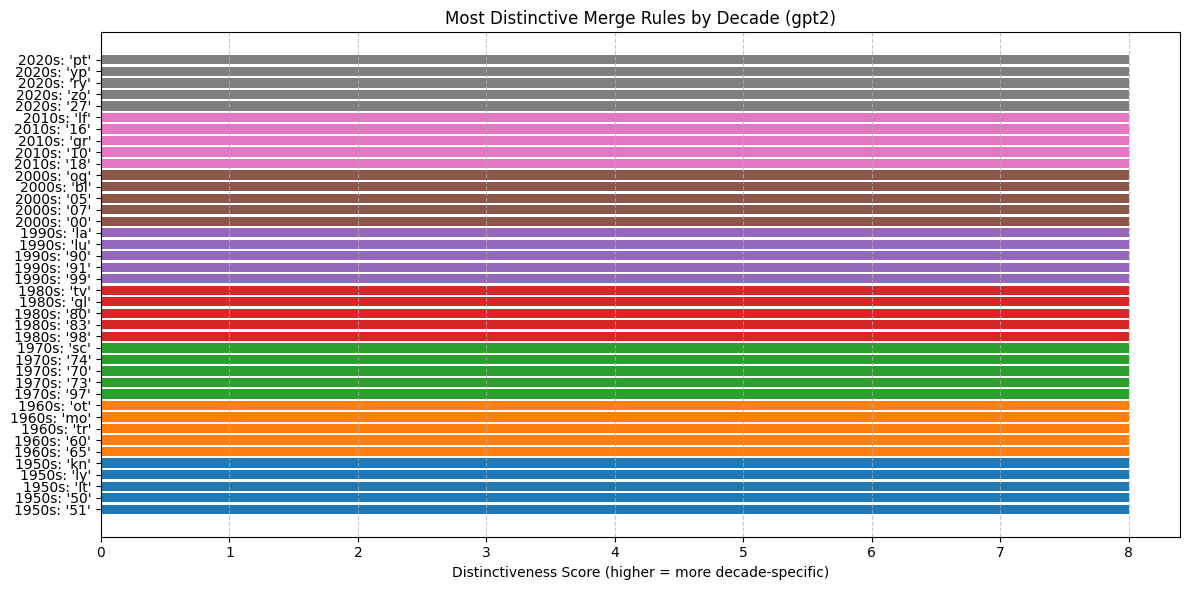

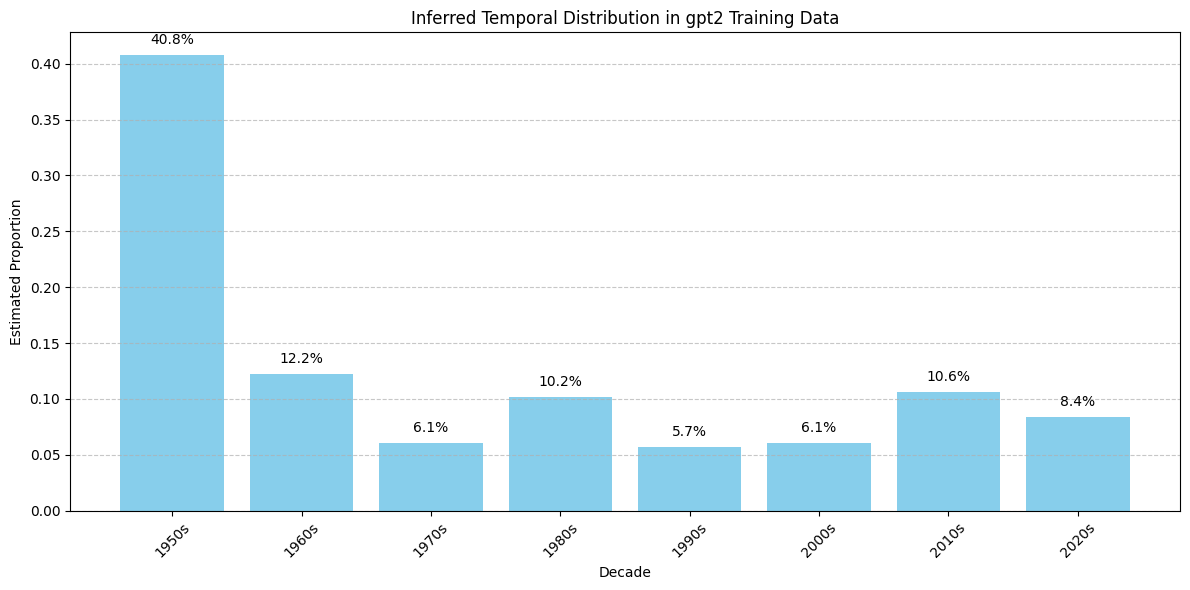

2025-03-12 23:41:01,299 - __main__ - INFO - Performing statistical validation with 20 bootstrap iterations...
2025-03-12 23:41:01,300 - __main__ - INFO - Running 20 bootstrap iterations...
Bootstrap Progress: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


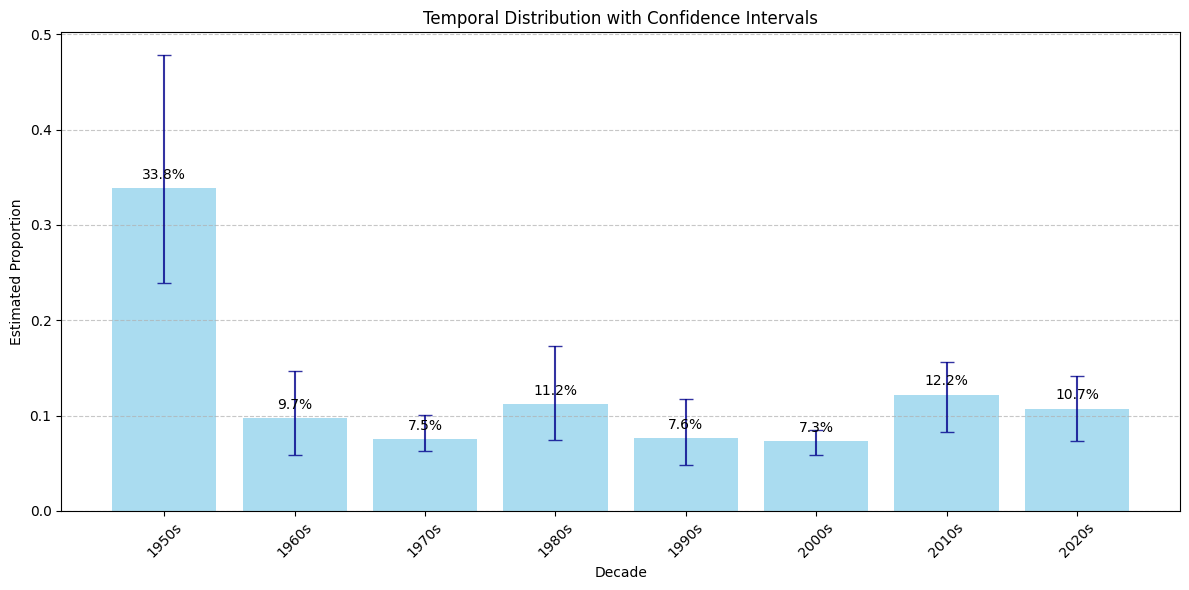

2025-03-12 23:41:17,991 - __main__ - INFO - Analysis reliability assessment:
2025-03-12 23:41:17,992 - __main__ - INFO - Reliability score: 52.2/100
2025-03-12 23:41:17,992 - __main__ - INFO - Coefficient of variation: 0.20
2025-03-12 23:41:17,992 - __main__ - INFO - Normalized CI width: 0.69
2025-03-12 23:41:17,997 - __main__ - INFO - Complete results saved to /Users/roshani/Downloads/MSc_AI_Project/temporal_tokenizer_analysis/results/gpt2_temporal_analysis.json



Temporal Distribution Summary:
1950s: 40.8% (95% CI: 23.9% - 47.8%)
1960s: 12.2% (95% CI: 5.8% - 14.7%)
1970s: 6.1% (95% CI: 6.3% - 10.0%)
1980s: 10.2% (95% CI: 7.4% - 17.3%)
1990s: 5.7% (95% CI: 4.8% - 11.8%)
2000s: 6.1% (95% CI: 5.9% - 8.5%)
2010s: 10.6% (95% CI: 8.2% - 15.6%)
2020s: 8.4% (95% CI: 7.4% - 14.2%)

Most Distinctive Decade Patterns:

1950s distinctive patterns:
  '51': 8.00x more common than average
  '50': 8.00x more common than average
  'It': 8.00x more common than average

1960s distinctive patterns:
  '65': 8.00x more common than average
  '60': 8.00x more common than average
  'tr': 8.00x more common than average

1970s distinctive patterns:
  '97': 8.00x more common than average
  '73': 8.00x more common than average
  '70': 8.00x more common than average

1980s distinctive patterns:
  '98': 8.00x more common than average
  '83': 8.00x more common than average
  '80': 8.00x more common than average

1990s distinctive patterns:
  '99': 8.00x more common than avera

In [13]:
# Run the complete temporal analysis pipeline for GPT-2
results = run_temporal_analysis(
    tokenizer_name="gpt2",
    texts_per_decade=10,  # Small number for testing, increase for better results
    bootstrap_iterations=20  # Fewer iterations for quick testing
)

# Print summary of findings
print("\nTemporal Distribution Summary:")
print("=" * 50)

# Sort decades chronologically
decades = sorted(results["analysis"]["temporal_distribution"].keys())

for decade in decades:
    proportion = results["analysis"]["temporal_distribution"][decade]
    ci = results["confidence_intervals"][decade]
    print(f"{decade}: {proportion:.1%} (95% CI: {ci['lower_ci']:.1%} - {ci['upper_ci']:.1%})")

print("\nMost Distinctive Decade Patterns:")
print("=" * 50)

for decade in decades:
    distinctive = results["analysis"]["distinctive_rules"][decade][:3]
    if distinctive:
        print(f"\n{decade} distinctive patterns:")
        for rule, score in distinctive:
            print(f"  '{rule}': {score:.2f}x more common than average")

## Future Improvements

To further enhance the reliability and accuracy of the temporal analysis:

1. **Larger Dataset Collection**:
   - Implement loaders for HathiTrust and Chronicling America archives
   - Add decade-specific term lists to improve temporal classification
   - Create balanced datasets representing different genres and styles

2. **Enhanced Statistical Validation**:
   - Implement cross-validation to assess model stability
   - Add Bayesian inference for better uncertainty quantification
   - Create synthetic datasets with known temporal distributions for validation

3. **Visual Analysis Tools**:
   - Create interactive visualizations for exploring temporal patterns
   - Add decade-level word frequency analysis to identify stylistic shifts
   - Compare multiple tokenizers in a single visualization

4. **Application to Multiple Models**:
   - Analyze temporal distributions across model families (GPT, BERT, Llama)
   - Compare results to self-reported training data distributions 
   - Identify correlations between temporal distributions and model performance